In [27]:
import torch
import pandas as pd
import torch.utils.data as data
import matplotlib.pyplot as plt
from src.error_measures import get_accuracy, get_error_measures, collect_stats, print_average_stats, gather_predictions
from src.models import MultiLayerANN, SynapticSNN, LeakySNN, DoubleLeakySNN
from src.train_model import training_loop, training_loop_stats
from src.graphs import one_graph, multiple_models_graph

In [28]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

### Parameter count

In [29]:
def list_parameters(model):
    all_params = 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            param = parameter.numel()
            print(f'Name: {name}, weights:{param}')
            all_params += param
    print(f"Number of parameters: {all_params}")

In [30]:
def count_parameters(model):
    all_params = 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            param = parameter.numel()
            all_params += param
    return all_params

In [31]:
model1 = MultiLayerANN(num_inputs=8, num_hidden=100, num_outputs=1)
model2 = LeakySNN(num_inputs=8, num_hidden=100, num_outputs=1)
model3 = SynapticSNN(num_inputs=8, num_hidden=100, num_outputs=1)
model4 = DoubleLeakySNN(num_inputs=8, num_hidden=100, num_outputs=1)

In [32]:
print("--- MultiLayerAnn ---")
list_parameters(model1)
print("--- LeakySNN ---")
list_parameters(model2)
print("--- SynapticSNN ---")
list_parameters(model3)
print("--- DoubleLeakySNN ---")
list_parameters(model4)

--- MultiLayerAnn ---
Name: lin1.weight, weights:800
Name: lin1.bias, weights:100
Name: lin2.weight, weights:10000
Name: lin2.bias, weights:100
Name: lin3.weight, weights:100
Name: lin3.bias, weights:1
Number of parameters: 11101
--- LeakySNN ---
Name: lin1.weight, weights:800
Name: lin1.bias, weights:100
Name: lif.threshold, weights:100
Name: lif.beta, weights:1
Name: lin2.weight, weights:100
Name: lin2.bias, weights:1
Number of parameters: 1102
--- SynapticSNN ---
Name: lin1.weight, weights:800
Name: lin1.bias, weights:100
Name: lif.threshold, weights:100
Name: lif.beta, weights:1
Name: lin2.weight, weights:100
Name: lin2.bias, weights:1
Number of parameters: 1102
--- DoubleLeakySNN ---
Name: lin1.weight, weights:800
Name: lin1.bias, weights:100
Name: lif1.threshold, weights:100
Name: lif1.beta, weights:1
Name: lif2.threshold, weights:100
Name: lif2.beta, weights:1
Name: lin2.weight, weights:100
Name: lin2.bias, weights:1
Number of parameters: 1203


In [33]:
weights = [[],[],[]]
hidden_values = [1, 2, 5, 15, 20, 25, 30, 35, 40]
for num_hidden in hidden_values:
    model1 = MultiLayerANN(num_inputs=8, num_hidden=num_hidden, num_outputs=1)
    model2 = LeakySNN(num_inputs=8, num_hidden=num_hidden, num_outputs=1)
    model4 = DoubleLeakySNN(num_inputs=8, num_hidden=num_hidden, num_outputs=1)
    weights[0].append(count_parameters(model1))
    weights[1].append(count_parameters(model2))
    weights[2].append(count_parameters(model4))

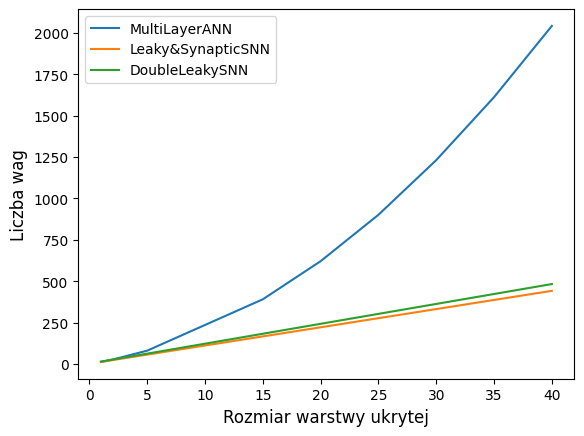

In [34]:
img = multiple_models_graph(hidden_values, weights, legend=["MultiLayerANN", "Leaky&SynapticSNN", "DoubleLeakySNN"],
                            x_label="Rozmiar warstwy ukrytej", y_label="Liczba wag", textsize=12)

In [36]:
data06 = pd.read_csv("../data/processed/target06.csv")
data06.drop(columns=["weekday"], inplace=True)

In [37]:
all_data = data.TensorDataset(torch.from_numpy(data06.values[:,:-1]).float(), torch.from_numpy(data06.values[:,-1]).float())
train_dataset, test_dataset = torch.utils.data.random_split(all_data, (round(0.8 * len(all_data)), round(0.2 * len(all_data))))
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

### Train models

In [38]:
model1 = MultiLayerANN(num_inputs=8, num_hidden=4000, num_outputs=1)
model2 = LeakySNN(num_inputs=8, num_hidden=4000, num_outputs=1, num_steps=25)
model3 = SynapticSNN(num_inputs=8, num_hidden=4000, num_outputs=1, num_steps=50)
model4 = DoubleLeakySNN(num_inputs=8, num_hidden=4000, num_outputs=1, num_steps=20)

In [39]:
training_loop(model1, train_loader, test_loader, device, num_epochs=1, lr=0.0005)
training_loop(model2, train_loader, test_loader, device, num_epochs=1, lr=0.0005)
training_loop(model3, train_loader, test_loader, device, num_epochs=1, lr=0.0005)
training_loop(model4, train_loader, test_loader, device, num_epochs=1, lr=0.0005)

TypeError: training_loop() got multiple values for argument 'num_epochs'

In [ ]:
def model_size(model):
    mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
    mem_bufs = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])
    return mem_params + mem_bufs # in bytes

In [ ]:
for param in model2.parameters(recurse=True):
    print(type(param), param.size())
batch = next(iter(test_loader))[0]

In [ ]:
print(model_size(model1))
print(model_size(model2))
print(model_size(model3))
print(model_size(model4))

In [ ]:
import time
time1 = time.time()
model1(batch)
time2 = time.time()
time2 - time1

In [ ]:
time1 = time.time()
model2(batch)
time2 = time.time()
time2 - time1

In [ ]:
time1 = time.time()
model3(batch)
time2 = time.time()
time2 - time1

In [ ]:
time1 = time.time()
model4(batch)
time2 = time.time()
time2 - time1

In [ ]:
def count_parameters(model):
    t_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        print(f'name: {name}, weights:{param}')
        t_params+=param
    print(f"Sum of trained paramters: {t_params}")
    return t_params
count_parameters(model2)